In [1]:
try:
    from turbojpeg import TurboJPEG
except:
    !conda install pyturbojpeg -c conda-forge -y

In [2]:
import os

import pandas as pd
from PIL import Image as im
from turbojpeg import TurboJPEG

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.models import resnet18 as ptm
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from torchmetrics import Accuracy, MeanMetric
from tqdm import tqdm

from sklearn.utils.class_weight import compute_class_weight

In [3]:
print(torch.__version__)
print(torchvision.__version__)
print(pl.__version__)

1.11.0
0.12.0
1.7.7


In [4]:
class PLDataModule(pl.LightningDataModule):
    def __init__(self, data_root, image_h_w, repetitions=0, batch_size=32, train_split=0.8, 
                 augmentation_transforms=None, num_workers=4):
        super().__init__()
        self.root = data_root
        self.image_h_w = image_h_w
        self.batch_size = batch_size
        self.train_split = train_split
        self.augmentation_transforms = augmentation_transforms
        self.num_workers = num_workers
        self.train_mean = torch.tensor([0.485, 0.456, 0.406])
        self.train_std = torch.tensor([0.229, 0.224, 0.225])
        self.cls_idx = dict()
        self.idx_cls = dict()
        #self.data_df = self.get_balanced_with_repetitions(repetitions=repetitions)
        self.data_df = self.get_metadata()
        self.common_transforms = transforms.Compose([
            transforms.ToPILImage(mode='RGB'),
            transforms.Resize((image_h_w, image_h_w)),
            #transforms.CenterCrop((224, 224)),
        ])
        
    def prepare_data_per_node(self):
        # There is nothing to prepare.
        # The data should have already been downloaded and
        # extracted in the data_root that is passed to initiaize this class
        print(os.path.abspath(self.root))
    
    def setup(self, stage='fit'):
        jpeg = TurboJPEG()
        to_tuple = lambda x, y: (x, y,)
        final_transformations = transforms.Compose([transforms.Lambda(lambda img: img/255),
                                                   transforms.Normalize(self.train_mean, self.train_std)])
        if stage =='fit':
            imgs_tensor, labels_tensor = self.read_get_img_tensors(self.data_df)
            
            # Split the dataset and apply transformations to the training dataset if specified
            imgs_ct = self.data_df.shape[0]
            train_split = torch.ceil(torch.tensor(imgs_ct * self.train_split)).to(int).item()
            
            train_tensor = imgs_tensor[:train_split]
            train_labels = labels_tensor[:train_split]
            val_tensor = imgs_tensor[train_split:]
            val_labels = labels_tensor[train_split:]
            
            #self.train_mean, self.train_std = self.compute_mean_std(train_tensor)
            
            if self.augmentation_transforms is not None:
                transform_lambda = lambda img: self.augmentation_transforms(img)
                tensor_list = list(map(transform_lambda, train_tensor))
                train_tensor = torch.stack(tensor_list, dim=0)
            
            #train_tensor = transforms.functional.normalize(train_tensor, self.train_mean, self.train_std)
            #val_tensor = transforms.functional.normalize(val_tensor, self.train_mean, self.train_std)
            train_tensor = final_transformations(train_tensor)
            val_tensor = final_transformations(val_tensor)
            
            self.train_set = tuple(map(to_tuple, train_tensor, train_labels))
            self.val_set = tuple(map(to_tuple, val_tensor, val_labels))
        elif stage == 'test':
            full_df = self.get_metadata()
            lj = full_df.join(d.data_df[['class']], how='left', rsuffix='_r')
            not_training = lj[lj.class_r.isna()].dropna(axis=1).dropna(axis=0).iloc[:512]
            imgs_tensor, labels_tensor = self.read_get_img_tensors(not_training)
            imgs_tensor = final_transformations(imgs_tensor)
            self.test_set = tuple(map(to_tuple, imgs_tensor, labels_tensor))
        elif stage == 'predict':
            pred_df = pd.read_csv(os.path.join(self.root, "test.csv"), index_col='id')
            pred_df['c_idx'] = [i for i in range(pred_df.shape[0])]
            pred_df['fpath'] = self.root + "/images/images/" + pred_df.index.astype('str') + ".jpg"
            pred_tensor, _ = self.read_get_img_tensors(pred_df)
            pred_tensor_norm = final_transformations(pred_tensor)
            self.predict_set = pred_tensor_norm
                                                           

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, 
                          shuffle=True, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, 
                          shuffle=False, num_workers=self.num_workers, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size * 4, 
                          shuffle=False, num_workers=self.num_workers, persistent_workers=True)
    
    def predict_dataloader(self):
        return DataLoader(self.predict_set, batch_size=self.batch_size * 4,
                         shuffle=False, num_workers=self.num_workers, persistent_workers=True)
    
    def teardown(self, stage='fit'):
        if stage == 'fit':
            del self.val_set
            del self.train_set
        elif stage == 'test':
            del self.test_set
    #############################
    ## Miscellaneous functions ##
    #############################
    def compute_mean_std(self, image_tensor):
        axes = (0,2,3)
        return image_tensor.mean(axis=axes), image_tensor.std(axis=axes)
    
    def get_balanced_with_repetitions(self, repetitions=39):
        df = self.get_metadata()
        groupby = df.groupby(['class'])
        gby_size = groupby.size()
        min_idx = gby_size.argmin()
        min_class, min_count = gby_size.index[min_idx], gby_size[min_idx]
        rep_subset = groupby.sample(min_count, replace=False, random_state=0)
        
        if repetitions > 0:
            keep = ['class_left', 'fpath_left', 'c_idx_left', 'class_right']
            sb = df.join(rep_subset, how='left', lsuffix='_left', rsuffix='_right')[keep]
            ## with rows not already in rep_subset
            sb = sb[sb.class_right.isna()][keep[:-1]] 
            new_subset = sb.groupby('class_left').sample(repetitions, replace=False, random_state=100)
            new_subset.rename(columns=dict(zip(new_subset.columns, df.columns)), inplace=True)
            min_class_repeats = df[df['class'] == min_class].sample(repetitions, random_state=100)
            rep_subset = pd.concat([rep_subset, new_subset, min_class_repeats], axis=0)
        
        # randomize rows
        rep_subset = rep_subset.sample(frac=1.0, random_state=10) 
        return rep_subset
    
    def get_metadata(self):
        df = pd.read_csv(os.path.join(self.root, "train.csv"), index_col='id')
        c_idx = dict(zip(df['class'].unique(), 
                                [i for i in range(len(df['class'].unique()))]))
        self.cls_idx = c_idx
        self.idx_cls = dict(zip(list(c_idx.values()), list(c_idx.keys())))
        df['fpath'] = list(map(lambda x: os.path.join(self.root, 'images/images', x+".jpg"), df.index.astype(str)))
        df['c_idx'] = list(map(lambda x: c_idx[x], df['class']))
        
        return df
    
    def read_get_img_tensors(self, df):
        jpeg = TurboJPEG()
        # open and read the image, decode it, convert it to RGB and then apply transforms
        imread = lambda x: self.common_transforms(jpeg.decode(open(x, 'rb').read())[:,:,[2,1,0]])
        imgs_list = list(map(imread, df.fpath))
        inter_tensor = list(map(transforms.functional.pil_to_tensor, imgs_list))
        imgs_tensor = torch.stack(inter_tensor, dim=0)
        labels_tensor = torch.tensor(df.c_idx.to_numpy(), dtype=torch.int64)
        
        return imgs_tensor, labels_tensor

In [5]:
class FoodType(pl.LightningModule):
    def __init__(self, learning_rate=3e-4, num_classes=13, image_h_w=10, class_weights=None):
        super().__init__()        
        self.save_hyperparameters()
        
        # to log the model graph on tensorboard
        self.example_input_array = torch.rand((1, 3, self.hparams.image_h_w, self.hparams.image_h_w))
        
        ### Pretrained Model to classify 13 image classes
        backbone = ptm(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(num_filters, self.hparams.num_classes))
        ### Loss function
        self.loss_fn = nn.CrossEntropyLoss()
        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        
        # Model Metrics for logging
        acc_obj = Accuracy(num_classes=self.hparams.num_classes)
        self.train_acc = acc_obj.clone()
        self.val_acc = acc_obj.clone()
        
        loss_obj = MeanMetric()
        self.train_loss = loss_obj.clone()
        self.val_loss = loss_obj.clone()
        # End Model Metrics for logging
        
    def forward(self, x):
        #self.feature_extractor.eval()
        #with torch.no_grad():
        representations = self.feature_extractor(x)
        x = self.classifier(representations)
        return x
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), 
                                lr=self.hparams.learning_rate,
                                weight_decay=0.00)
    
    def on_train_epoch_start(self):
        super().on_train_epoch_start()

        # Reset state variables for train metrics to 
        # their default values before start of each epoch
        self.train_acc.reset()
        self.train_loss.reset()

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        pred = self(imgs)
        loss = self.loss_fn(pred, labels)
        probs = F.softmax(pred, dim=1)
        pred_classes = probs.argmax(dim=1)
        
        # accumulate training accuracy for each batch
        acc = self.train_acc(pred_classes, labels)
        # accumulate training loss for each batch
        self.train_loss(loss)
        
        self.log("train/batch_loss", loss, prog_bar=False, sync_dist=True)
        self.log("train/batch_acc", acc, prog_bar=False, sync_dist=True)

        return loss
    
    def training_epoch_end(self, training_step_outputs):
        avg_train_acc = self.train_acc.compute()
        avg_train_loss = self.train_loss.compute()
        self.log("train/loss", avg_train_loss, prog_bar=True, sync_dist=True)
        self.log("train/acc", avg_train_acc, prog_bar=True, sync_dist=True)
        # Set X-axis as epoch number for epoch-level metrics
        self.log("step", float(self.current_epoch), sync_dist=True)
        
    def on_validation_epoch_start(self):
        super().on_validation_epoch_start()
        # Reset state variables for validation metrics to 
        # their default values before start of each epoch
        self.val_acc.reset()
        self.val_loss.reset()
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        output = self(imgs)
        loss = self.loss_fn(output, labels)
        prob = F.softmax(output, dim=1)
        pred_classes = prob.argmax(dim=1)
        
        # accumulate validation accuracy for each batch
        self.val_acc(pred_classes, labels)
        self.val_loss(loss)
        
        return loss
    
    def validation_epoch_end(self, validation_step_outputs):
        avg_val_loss = self.val_loss.compute()
        avg_val_acc = self.val_acc.compute()
        self.log('val/loss', avg_val_loss, prog_bar=True, sync_dist=True)
        self.log('val/acc', avg_val_acc, prog_bar=True, sync_dist=True)
        self.log("step", float(self.current_epoch), sync_dist=True)
        
    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        pred = self(imgs)        
        loss = self.loss_fn(pred, labels)
        prob = F.softmax(pred, dim=1)
        pred_classes = prob.argmax(dim=1)
        test_acc = torch.where(pred_classes == labels, 1, 0).to(torch.float32).mean()
        self.log('test/loss', loss, sync_dist=True)
        self.log('test/acc', test_acc, sync_dist=True)
    
    def predict_step(self, batch, batch_idx):
        pred = self(batch)
        prob = F.softmax(pred, dim=1)
        pred_classes = prob.argmax(dim=1)
        return pred_classes

In [6]:
def init_bias(m):
    if isinstance(m, nn.Linear):
        m.bias.data.fill_(1/13)

In [7]:
augmentation_transforms = transforms.RandomApply([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
], p=0.00)

In [8]:
pl.seed_everything(10, workers=True)
image_h_w = 224
num_classes = 13

d = PLDataModule("../input/opencv-pytorch-dl-course-classification", image_h_w=image_h_w, 
                 repetitions=39, batch_size=16, train_split=0.80,
                 augmentation_transforms=augmentation_transforms, num_workers=2)

class_wts = None #torch.tensor(compute_class_weight('balanced', classes=range(num_classes), y=d.get_metadata()['c_idx'].to_numpy()), dtype=torch.float32)

m = FoodType(learning_rate=0.000002, num_classes=num_classes, image_h_w=image_h_w, 
             class_weights=class_wts).apply(init_bias)

#ck = torch.load('/kaggle/working/kenyanFood-val_loss1.21.ckpt')
#m.load_state_dict(ck['state_dict'])
#m = m.load_from_checkpoint(checkpoint_path='/kaggle/working/kenyanFood-val_loss1.15.ckpt', strict=True)

In [9]:
r = torch.rand((1, 3, image_h_w, image_h_w))
print(m.forward(r).shape)
del r

torch.Size([1, 13])


In [10]:
checkpoint_callback = ModelCheckpoint(
        monitor='val/loss',
        dirpath='./checkpoints',
        filename='kenyanFood-val_loss{val/loss:.2f}',
        auto_insert_metric_name=False, 
        save_weights_only=True)

early_stopping = EarlyStopping(monitor='val/loss', patience=3, mode='min')

logger = TensorBoardLogger(save_dir='./logs', name='fullModelTraining', log_graph=True)

In [11]:
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     fast_dev_run=False,
                     enable_progress_bar=True,
                     enable_checkpointing=True,
                     logger=logger,
                     enable_model_summary=True,
                     deterministic='warn',
                     log_every_n_steps=20,
                     #overfit_batches=1,
                     max_epochs=300,
                     check_val_every_n_epoch=1,
                     callbacks=[checkpoint_callback, early_stopping])

In [12]:
%%time
trainer.fit(m, d)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CPU times: user 18min 7s, sys: 1min 27s, total: 19min 34s
Wall time: 21min 1s


%%time
trainer.test(m, d)

m = m.load_from_checkpoint(checkpoint_path='/kaggle/working/kenyanFood-val_loss0.91.ckpt', strict=True)

In [13]:
%%time
pred_idx = trainer.predict(m, d)

Predicting: 327it [00:00, ?it/s]

CPU times: user 51.6 s, sys: 3.29 s, total: 54.9 s
Wall time: 1min 3s


In [14]:
final = []
for i in range(len(pred_idx)):
    final = final + [d.idx_cls[j.item()] for j in pred_idx[i]]

In [15]:
test = pd.read_csv(os.path.join(d.root, 'test.csv'), index_col='id')
test['class'] = final
print(test.shape)
test.head()

(1638, 1)


,class
id,
9156739011499789258,nyamachoma
2049465964503133373,kachumbari
6446998501027132988,nyamachoma
4194396063119815321,ugali
9018117998187006009,ugali


In [16]:
test.to_csv('./submission.csv')

nyamachoma, kachumbari, nyamachoma, ugali, ugali, masalachips, nyamachoma, kachumbari, matoke, chapati, 

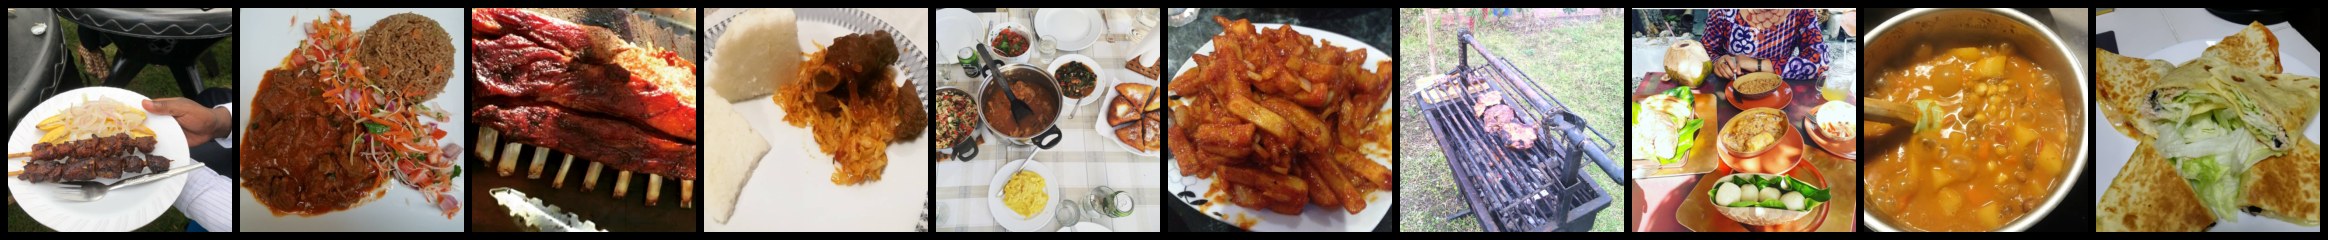

In [17]:
grid = torch.empty((10, 3, image_h_w, image_h_w), dtype=torch.uint8)

for i in range(grid.shape[0]):
    #a, b = d.train_set[i]
    a = d.predict_set[i]
    u = (a.permute(1,2,0) * d.train_std + d.train_mean) * 255
    u = u.clamp(0, 255).permute(2,0,1).to(torch.uint8) 
    grid[i] = u
    print(final[i], end=", ")
    #print(d.idx_cls[b.item()], end=', ')

im.fromarray(torchvision.utils.make_grid(grid, nrow=10, padding=8).permute(1,2,0).numpy())

# Tensorboard Dev logs link

https://tensorboard.dev/experiment/spODJKpnSLOePQKPqdVmgg/

# Profile Link

https://www.kaggle.com/krualkk23